<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/ML/blob/main/TimeSeries/BusinessCaseCompleted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Packages

In [120]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [121]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [122]:
df_single_level_cols = pd.DataFrame([[2,3,9]],
                                    index=['cat', 'dog','lo' ],
                                    columns=['weight', 'height','higher'])


In [123]:
(df_single_level_cols.stack()).count()

9

In [124]:
multi = pd.MultiIndex.from_tuples([('weight' , 'kg'), ('height' , 'm')])
df_multi_level_cols = pd.DataFrame([[3,3],[8,9]],index=['KOK', 'Pad'] , columns=multi)

In [125]:
df_multi_level_cols

,weight,height
,kg,m
KOK,3,3
Pad,8,9


In [126]:
df_multi_level_cols.stack()

height  weight
KOK kg     NaN     3.0
    m      3.0     NaN
Pad kg     NaN     8.0
    m      9.0     NaN

In [127]:
df_multi_level_cols.stack([1,0])

KOK  kg  weight    3.0
     m   height    3.0
Pad  kg  weight    8.0
     m   height    9.0
dtype: float64

In [128]:
df_multi_level_cols.stack([0,1])

KOK  height  m     3.0
     weight  kg    3.0
Pad  height  m     9.0
     weight  kg    8.0
dtype: float64

In [129]:
df = raw_data.copy()

In [130]:
df.isnull().sum()

PAH3.DE  Open      3165
         High      3165
         Low       3165
         Close     3165
         Volume    3165
BMW.DE   Open         0
         High         0
         Low          0
         Close        0
         Volume       0
VOW3.DE  Open       443
         High       443
         Low        443
         Close      443
         Volume     443
dtype: int64

## Defining Key Dates

In [131]:
# Starting Date
start_date = "2009-04-05" 

# First Official Announcement - 49.9%
ann_1 = "2009-12-09" 

# Second Official Announcement - 51.1%
ann_2 = "2012-07-05" 

#Ending Date
end_date = "2014-01-01"
# end year in the course
end_data_set = "2019-12-20"
# Dieselgate
d_gate = '2015-09-20' 

## Pre-processing the Data

In [132]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [133]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [134]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

## Plotting the Prices

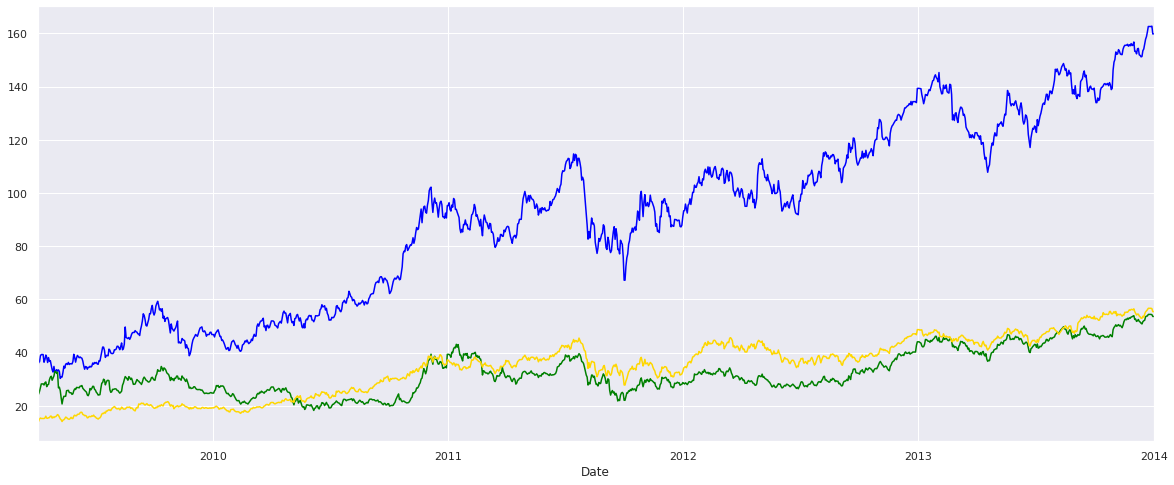

In [135]:
df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.show()

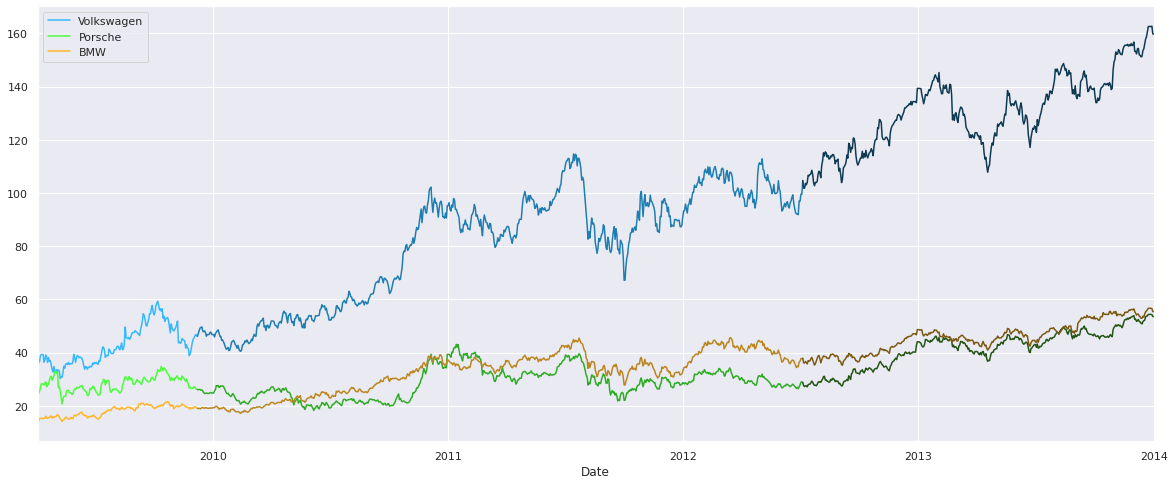

In [136]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

In [137]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08,32.022873,25.596832,9.333747,-4.40564,-3.831317,-0.269670,19.40966,14.678988,0.072722,56336.0,901566.0,767000.0
1996-11-11,32.022873,25.596832,9.308577,-4.40564,-3.831317,-0.269670,19.40966,14.678988,0.072722,56336.0,901566.0,260000.0
1996-11-12,32.022873,25.596832,9.378950,-4.40564,-3.831317,0.756007,19.40966,14.678988,0.571547,56336.0,901566.0,1066000.0
1996-11-13,32.022873,25.596832,9.364052,-4.40564,-3.831317,-0.158848,19.40966,14.678988,0.025233,56336.0,901566.0,793000.0
1996-11-14,32.022873,25.596832,9.394358,-4.40564,-3.831317,0.323640,19.40966,14.678988,0.104743,56336.0,901566.0,351000.0


## Correlation

In [138]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359546999044846
Volkswagen and BMW correlation: 	0.9799378234838013
Porsche and BMW correlation: 		0.8052157721431455


In [139]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633583095645341
Volkswagen and BMW correlation: 	0.8427606940711273
Porsche and BMW correlation: 		0.6095038872684173


In [140]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428267957523109
Volkswagen and BMW correlation: 	0.979594303250648
Porsche and BMW correlation: 		0.7042723492051917


In [141]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237244550604
Volkswagen and BMW correlation: 	0.9284447375360486
Porsche and BMW correlation: 		0.9494111711684651


In [142]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:end_data_set].corr(df['por'][end_date:end_data_set])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:end_data_set].corr(df['bmw'][end_date:end_data_set])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:end_data_set].corr(df['bmw'][end_date:end_data_set])))

Correlation among manufacturers from 2014-01-01 to 2022-11-22 00:00:00

Volkswagen and Porsche correlation: 	0.9693559116622297
Volkswagen and BMW correlation: 	0.5403673547526507
Porsche and BMW correlation: 		0.5128685626533542


## Best Fitting Models

In [143]:
df.columns

MultiIndex([(    'vol', ''),
            (    'por', ''),
            (    'bmw', ''),
            ('ret_vol', ''),
            ('ret_por', ''),
            ('ret_bmw', ''),
            ( 'sq_vol', ''),
            ( 'sq_por', ''),
            ( 'sq_bmw', ''),
            (  'q_vol', ''),
            (  'q_por', ''),
            (  'q_bmw', '')],
           )

### For Volkswagen

In [144]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [145]:
print(mod_pr_pre_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -325.261
Date:                Wed, 23 Nov 2022   AIC                            652.523
Time:                        00:20:58   BIC                            655.699
Sample:                    04-06-2009   HQIC                           653.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3103      0.128     17.983      0.000       2.059       2.562
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Pr

In [146]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1418.167
Date:                Wed, 23 Nov 2022   AIC                           2840.335
Time:                        00:20:58   BIC                           2849.352
Sample:                    12-09-2009   HQIC                          2843.827
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0899      0.034      2.645      0.008       0.023       0.156
sigma2         4.0114      0.160     24.998      0.000       3.697       4.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                85.28
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
print(mod_pr_post_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -806.543
Date:                Wed, 23 Nov 2022   AIC                           1617.085
Time:                        00:20:58   BIC                           1625.012
Sample:                    07-05-2012   HQIC                          1620.228
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0879      0.047      1.861      0.063      -0.005       0.180
sigma2         3.7019      0.193     19.175      0.000       3.324       4.080
Ljung-Box (L1) (Q):                   0.02   Jarque-

### For Porsche

In [148]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [149]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -251.149
Date:                Wed, 23 Nov 2022   AIC                            504.297
Time:                        00:21:05   BIC                            507.473
Sample:                    04-06-2009   HQIC                           505.585
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9999      0.053     19.004      0.000       0.897       1.103
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -806.676
Date:                Wed, 23 Nov 2022   AIC                           1617.352
Time:                        00:21:05   BIC                           1626.369
Sample:                    12-09-2009   HQIC                          1620.844
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1096      0.032      3.457      0.001       0.047       0.172
sigma2         0.6482      0.020     32.054      0.000       0.609       0.688
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               483.16
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -407.475
Date:                Wed, 23 Nov 2022   AIC                            818.950
Time:                        00:21:05   BIC                            826.877
Sample:                    07-05-2012   HQIC                           822.092
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0640      0.035      1.824      0.068      -0.005       0.133
sigma2         0.4757      0.027     17.659      0.000       0.423       0.529
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                25.52
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.14
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

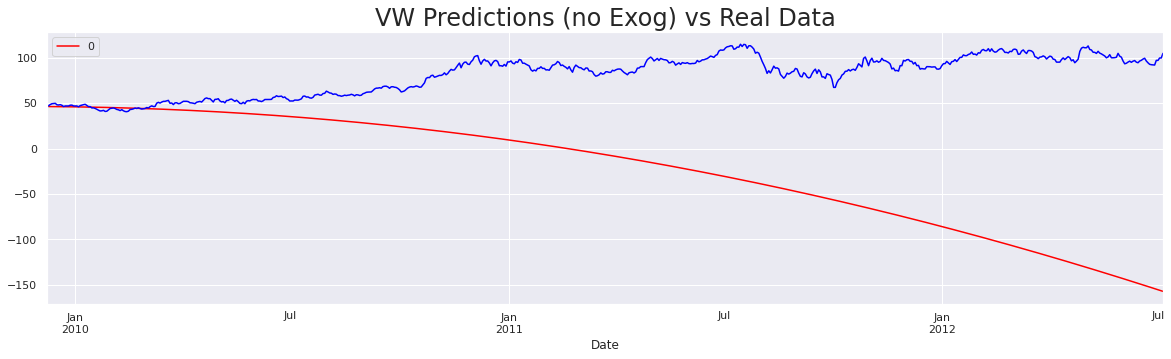

In [152]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

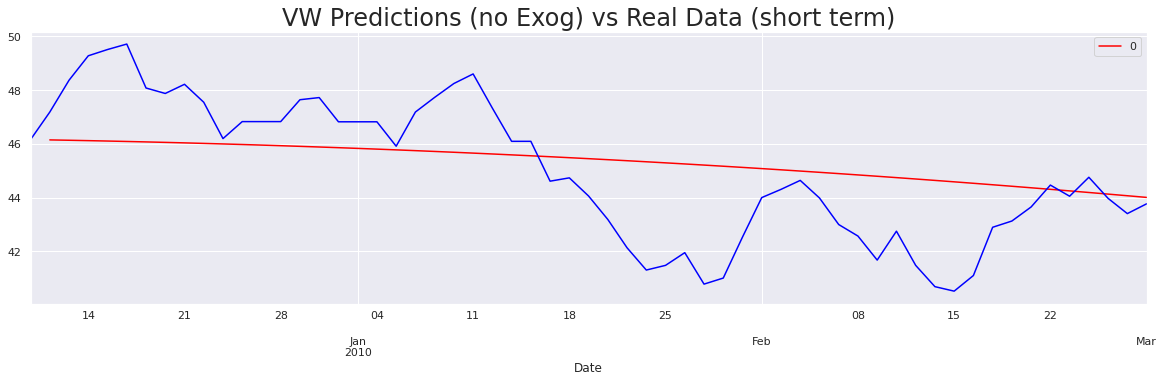

In [153]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### For Volkswagen

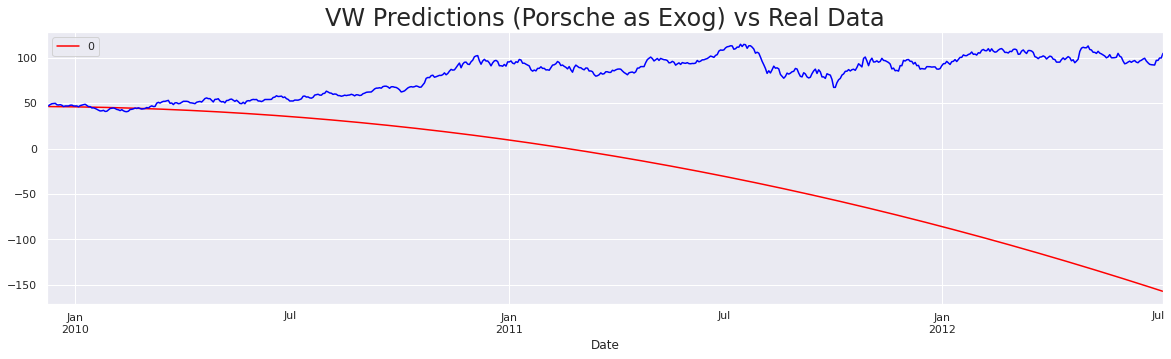

In [162]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)
plt.show()

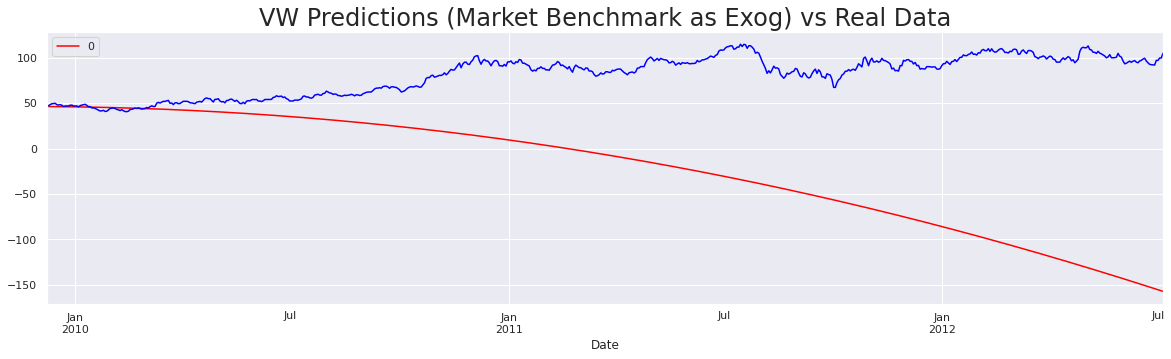

In [155]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

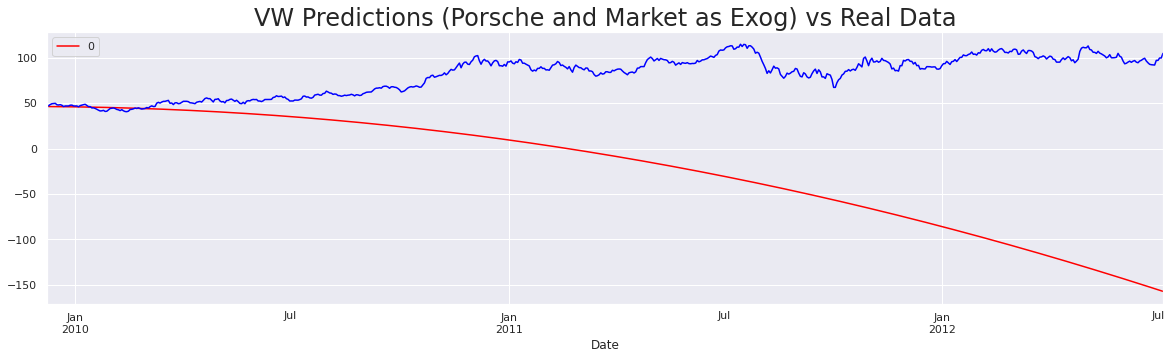

In [156]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por', 'bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['por','bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.show()

## Volatility

### Volatility of VW for Each Period

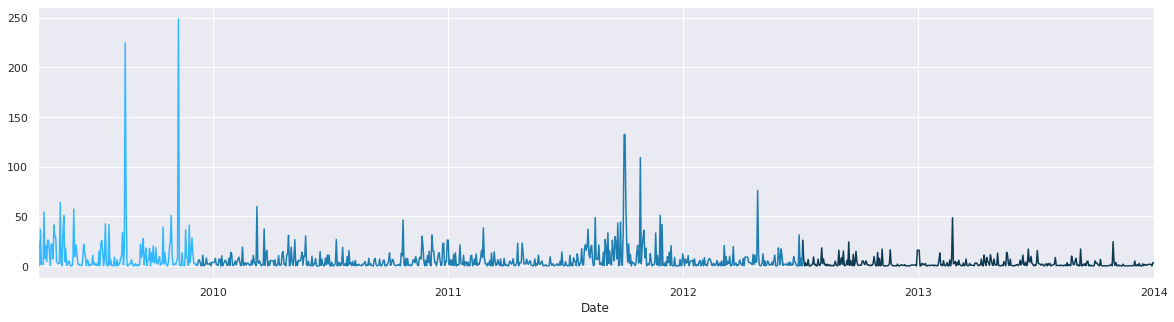

In [163]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for Each Period

In [158]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7774332406584
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.0030441418911
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9903938892228
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.99039383692866
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7535921415933
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.731661458985
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7316614577403
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5622435425123
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5578870226161
            Iterations: 7
            F

In [159]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.990
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Wed, Nov 23 2022   Df Residuals:                      177
Time:                        00:21:16   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.195e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    1.6143e-12      0.349  4.623e-12      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [160]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Wed, Nov 23 2022   Df Residuals:                      671
Time:                        00:21:16   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [161]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Wed, Nov 23 2022   Df Residuals:                      389
Time:                        00:21:16   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""